# 该程序是用来将LoveDA在Val数据集的预测结果可视化并保存的

In [18]:
# 导入所需要用到的包
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import time
import torch.nn.functional as F
from numpy import *
from matplotlib import pyplot as plt
from PIL import Image
import d2l
import os
import numpy as np
from measure import SegmentationMetric
from dataset import img_dataset   # from xx.py文件 import里面的函数


from model_file.DRCANet import DRCANet
from model_file.MACUNet import MACUNet   #MACUNet模型
from model_file.MANet import MANet   #MACUNet模型

from early_stopping import EarlyStopping
from tqdm import tqdm, trange
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
torch.backends.cudnn.enabled =True
# torch.backends.cudnn.benchmark = True
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

%config InlineBackend.figure_format = 'svg'

In [19]:
print(torch.cuda.device_count())

2


In [20]:
#一些参数的设置
batch_size=1
class_num = 8   #类别数 忽略-0 背景-1、建筑-2、道路-3、水-4、贫瘠-5、森林-6、农业-7。没有数据的区域被指定为0，应该忽略 
cuda = True
num_workers = 12 #读入数据时候的线程
band = 3       #通道数，RGB则为3,遥感图像还有其他多光谱的
# net = DRCANet(class_num)   #MACUNET网络##########################################################修改网络名字

################LoveDA全部数据################
# train_path = '/root/master/ATL/MACU-Net-master/data/LoveDA/Train/Urban' #训练集地址
val_path = '/root/master/ATL/dataset/LoveDA_1024/Val/Urban'     #验证集地址


num_GPU = 1  #GPU的个数

# torch.cuda.set_device(0) #设置设备为GPU0？？？？？如果是多个GPU呢？？？
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [21]:
##########数据增强的方法，会直接应用到Dataset的 __getitem__(),Dataloader是通过调用__getitem__()来返回数据集的！
val_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),#先除以255归一化
                                                torchvision.transforms.Normalize(mean=[.485, .456, .406],std=[.229, .224, .225])])

In [22]:
# ################加载训练集和验证集############
data_val = img_dataset(val_path, val_transform)
data_loader_val = torch.utils.data.DataLoader(dataset=data_val,
                                                # 这里注意batch size要对应放大倍数
                                                batch_size = 1, 
                                                shuffle = True,num_workers=12)
real_imgs = img_dataset(val_path)

print('-----------------------------------------')    
if data_val.__len__()!= 0:
    print(f'  -Val Dataset load successfully! total {data_val.__len__()}')
    print('  -Val Dataset images shape',data_val.__getitem__(0)[0].shape)
    print('  -Val Dataset label shape',data_val.__getitem__(0)[1].shape)
else:
    print('  --Val dataset load fail--')
print('-----------------------------------------')    

-----------------------------------------
  -Val Dataset load successfully! total 677
  -Val Dataset images shape torch.Size([3, 1024, 1024])
  -Val Dataset label shape (1024, 1024)
-----------------------------------------


In [23]:
# 加载模型并进行预测！！
########################################## 可视化预测值
GID_COLOR_MAP = dict(
    IGNORE=(0, 0, 0),
    Background=(255, 255, 255), #1-背景-白色
    Building=(255, 0, 0), #2-建筑-红色
    Road=(255, 255, 0), #3-道路-黄色
    Water=(0, 0, 255), #4-水-蓝色
    Barren=(159, 129, 183),#5-贫瘠-
    Forest=(0, 255, 0),#6-森林 绿色
    Agricultural=(255, 195, 128), #7-农业用地-肉色  
)

def render(mask_image):
    new_mask = mask_image.astype(np.uint8) #把原来的图片读出来，存成uint8的格式
    cm = np.array(list(GID_COLOR_MAP.values())).astype(np.uint8) #取出COLOR_MAP中的值，存到列表
    color_img = cm[new_mask]  #这里就变成1024*1024*3的了？ why？？
    color_img = Image.fromarray(np.uint8(color_img)) #从np的array格式转换成PIL格式
    return color_img

In [24]:
###################加载模型，加载参数########################
model_path = '/root/master/ATL/code/MACUNet/checkpoint/LoveDA/macunet/05-07-13_31_01/model_weights.pth'
save_file_path = '/root/master/ATL/code/MACUNet/结果图/LoveDA/MACUNet/batch32_2gpu_mIoU0.32'

# net_predict = DRCANet(class_num) #在服务器上，可以用cuda去预测，这里自己的电脑放不下！！
# net_predict = MANet(band,class_num) #在服务器上，可以用cuda去预测，这里自己的电脑放不下！！
net_predict = MACUNet(band,class_num) #在服务器上，可以用cuda去预测，这里自己的电脑放不下！！

net_predict = nn.DataParallel(net_predict);   #多gpu训练的模型，要加这一句才行
net_predict.load_state_dict(torch.load(model_path)) #如果在服务器，不需要map_location='cuda:0'
net_predict.cuda();

In [25]:
################读取一张需要进行预测的图片######################
try:
    os.makedirs(save_file_path) #生成一个outfile的文件夹
except OSError:
    pass

In [26]:
# save_path =os.path.join(save_file_path,data_val.images_list[0])
# save_path

In [27]:
# real_img = real_imgs.__getitem__(0)[0]
# real_img.shape

In [28]:
# real_img = data_val.__getitem__(0)[0]
# real_img.shape

保存ing...:   2%|▏         | 1/50 [00:02<01:53,  2.32s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

共保存完成 50 张图像, 耗时 876.4982686042786 秒


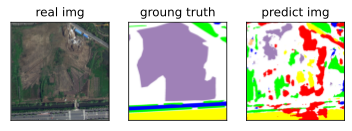

In [29]:
start = time.time()    
for i in trange(50,desc='保存ing...'):
    real_img = real_imgs.__getitem__(i)[0]
    
    X = data_val.__getitem__(i)[0]  #更换要读取的图片 ######  real img的地址
    
    X = X.unsqueeze(0) #变成四维的张量
    Y = net_predict(X.cuda()).argmax(dim=1) #X.cuda()#因为训练的时候读进来的数据集-1，所以现在需要加上1 #进行预测！！！
    Y.shape
    Y = Y.reshape(Y.shape[1], Y.shape[2]) #变成(1024,1024)
    Y.shape
    predict_images= Y.cpu().numpy()

    ########################################## 可视化预测值
    predict_img = render(predict_images)

    ############################################ 读取vis_png 进行比较
    vis_png_path = val_path + '/vis/'+data_val.images_list[i]
    guound_truth_img = np.array(Image.open(vis_png_path))

    #################################################画图并保存文件
    plt.subplot(1,3,1),plt.imshow(real_img),plt.title('real img'),plt.xticks([]),plt.yticks([]) #隐藏掉坐标轴
    plt.subplot(1,3,2),plt.imshow(guound_truth_img),plt.title('groung truth'),plt.xticks([]),plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(predict_img),plt.title('predict img'),plt.xticks([]),plt.yticks([])

    f = plt.gcf()
    save_path = os.path.join(save_file_path,data_val.images_list[i])
    f.savefig(save_path,dpi=800,bbox_inches = 'tight')

end = time.time()
print(f'共保存完成 {50} 张图像, 耗时 {end-start} 秒')